In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import pickle
import numpy as np

X = pickle.load(open("X.pickle", "rb"))
y = pickle.load(open("y.pickle", "rb"))

# Model

In [2]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

**Creating checkpoints so we can save progress during training;**

In [3]:
# For each time we reach the best the validation accuracy, we will upload a new file (Or checkpoint) during training
model_checkpoint_callback = ModelCheckpoint("Brain_model_best.h5", 
                                            save_best_only=True)

early_stop = EarlyStopping(monitor='val_accuracy', mode='max',
                       patience=2,
                       restore_best_weights=True,
                       verbose=1)

**Building CNN and training:**

In [4]:
# Scaling our data between 0-1
X = X/255.0
y = np.array(y) # MUST CONVERT y TO AN ARRAY OR ELSE WE GET ERRORS WHEN FITTING
KERNEL_SIZE_ = 4
POOL_SIZE_ = 5

model = Sequential()


# First layer
model.add(Conv2D(70, 
          kernel_size=(KERNEL_SIZE_, KERNEL_SIZE_), # Size of our kernel during Convolution
          input_shape=X.shape[1:], # The shape of X should return (3000, 220, 250, 1) (But we don't need the 3000, which is how many feature sets we have)
          padding="same") # 0 padding
         )
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(POOL_SIZE_,POOL_SIZE_)))

# Second layer
model.add(Conv2D(70, kernel_size=(KERNEL_SIZE_, KERNEL_SIZE_), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(POOL_SIZE_, POOL_SIZE_)))

# Third Layer - Flatten the 2D image to make it fit into our 1D dense layer
model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))

# Fourth Layer - Output layer
model.add(Dense(1))
model.add(Activation("sigmoid"))



model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Out of our entire training data, part of it (Which is 10% in this case) is our validation
model.fit(X, y, batch_size=64, validation_split=0.1, epochs=15,  callbacks=[model_checkpoint_callback, early_stop])


Epoch 1/15
43/43 [==============================] - 11s 242ms/step - loss: 0.5604 - accuracy: 0.7141 - val_loss: 0.4907 - val_accuracy: 0.7700
Epoch 2/15
43/43 [==============================] - 10s 239ms/step - loss: 0.4298 - accuracy: 0.8026 - val_loss: 0.3433 - val_accuracy: 0.8633
Epoch 3/15
43/43 [==============================] - 11s 249ms/step - loss: 0.3466 - accuracy: 0.8641 - val_loss: 0.3097 - val_accuracy: 0.8667
Epoch 4/15
43/43 [==============================] - 11s 249ms/step - loss: 0.2582 - accuracy: 0.9037 - val_loss: 0.2055 - val_accuracy: 0.9400
Epoch 5/15
43/43 [==============================] - 11s 254ms/step - loss: 0.1949 - accuracy: 0.9300 - val_loss: 0.1553 - val_accuracy: 0.9567
Epoch 6/15
43/43 [==============================] - 11s 259ms/step - loss: 0.1466 - accuracy: 0.9578 - val_loss: 0.1221 - val_accuracy: 0.9700
Epoch 7/15
43/43 [==============================] - 11s 246ms/step - loss: 0.1043 - accuracy: 0.9733 - val_loss: 0.0995 - val_accuracy: 0.9733

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 70, 70, 70)        1190      
                                                                 
 activation (Activation)     (None, 70, 70, 70)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 70)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 70)        78470     
                                                                 
 activation_1 (Activation)   (None, 14, 14, 70)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 70)         0         
 2D)                                                    

# Analysis of Our Model

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
losses = pd.DataFrame(model.history.history)

Text(0, 0.5, 'Percentage')

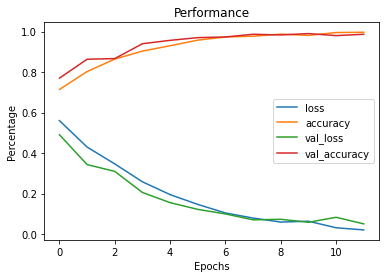

In [7]:
losses.plot()
plt.title("Performance")
plt.xlabel("Epochs")
plt.ylabel("Percentage")

# Training Our Model

In [10]:
from tensorflow.keras.models import load_model
import cv2
import os

**Predicting some samples to see if it works**

In [4]:
# Loading our model and training it
model = load_model("Brain_model_best.h5")

In [72]:
CLASS_NAMES = ["no", "yes"]


def pre_process(img):
    IMG_SIZE = 70
    img_array = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [73]:
import imageio

1/1 [==============================] - 0s 33ms/step
yes


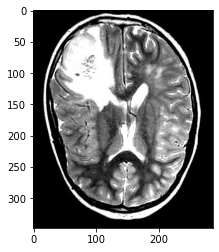

In [74]:
DATADIR = os.path.join(os.getcwd(), "archive\yes")
image = os.path.join(DATADIR, "y0.jpg")
prediction = model.predict([pre_process(image)]) # REMEMBER: Predict takes in a list

plt.imshow(imageio.imread(image))
print(CLASS_NAMES[int(prediction[0][0])])

1/1 [==============================] - 0s 20ms/step
no


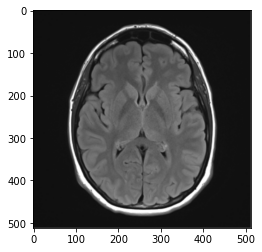

In [75]:
DATADIR = os.path.join(os.getcwd(), "archive\pred")
image = os.path.join(DATADIR, "pred47.jpg")
prediction = model.predict([pre_process(image)]) # REMEMBER: Predict takes in a list

plt.imshow(imageio.imread(image))
print(CLASS_NAMES[int(prediction[0][0])])
# int(prediction[0][0])

**Predicting all test predictions and analyzing the data**

In [100]:
filepaths = list()
CLASS_NAMES = ["no", "yes"]
ARCHIVE_DIR = os.path.join(os.getcwd(), "archive/test")

for cn in CLASS_NAMES:
    path = os.path.join(ARCHIVE_DIR, cn)
    for img in os.listdir(path):
        filepaths.append(os.path.join(path, img))
        
file_dict = {"filepath": filepaths}
df = pd.DataFrame(file_dict)

In [101]:
actual_col = list()
predicted_col = list()
shuffled = df.sample(frac=1)

for index, row in shuffled.iterrows():
    # Predicting each image in the test folder and putting that into our dataframe
    p = model.predict([pre_process(row["filepath"])])
    predicted_col.append(CLASS_NAMES[int(p[0][0])]) # Predictions made by machine
    actual_col.append(row["filepath"].split('\\')[-2]) # Actual results

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 32ms/step


In [102]:
pred_vs_actual = {"Predicted": predicted_col, "Actual": actual_col}
addon = pd.DataFrame(pred_vs_actual)

In [103]:
shuffled = pd.concat([shuffled, addon], axis=1)

In [104]:
shuffled

filepath Predicted Actual
742  C:\Users\Justin\Documents\Summer 2022 Research...       yes    yes
590  C:\Users\Justin\Documents\Summer 2022 Research...        no     no
475  C:\Users\Justin\Documents\Summer 2022 Research...       yes    yes
222  C:\Users\Justin\Documents\Summer 2022 Research...        no     no
737  C:\Users\Justin\Documents\Summer 2022 Research...       yes     no
..                                                 ...       ...    ...
582  C:\Users\Justin\Documents\Summer 2022 Research...       yes    yes
624  C:\Users\Justin\Documents\Summer 2022 Research...        no     no
362  C:\Users\Justin\Documents\Summer 2022 Research...        no     no
180  C:\Users\Justin\Documents\Summer 2022 Research...       yes     no
51   C:\Users\Justin\Documents\Summer 2022 Research...       yes    yes

[900 rows x 3 columns]

In [105]:
shuffled.to_csv("predictions") # Saving all of my predictions data to a csv